# Test the performance of MDM vs QDM + Sort for the globe for different CMIP6 models

In [1]:
from matplotlib import pyplot as plt
import xarray as xr
import numpy as np
import dask_jobqueue
import dask
from distributed import Client
from dask.diagnostics import progress
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature
import intake
import fsspec
import cftime
from datetime import datetime, timedelta
import pandas as pd
import xskillscore as xs

In [2]:
import dask 
from dask_jobqueue import PBSCluster
from dask.distributed import Client
from dask.distributed import performance_report

In [3]:
chic_lat  = 41.8781
chic_lon  = (360-87.6298)%360
ben_lat   = 12.9716
ben_lon   = 77.5946
########## CONUS ############
#CONUS lat-lon
top       = 50.0 # north lat
left      = -124.7844079+360 # west long
right     = -66.9513812+360 # east long
bottom    =  24.7433195 # south lat
################################
rda_scratch = '/gpfs/csfs1/collections/rda/scratch/harshah'
rda_url     =  'https://data.rda.ucar.edu/'
rda_data    = '/gpfs/csfs1/collections/rda/data/harshah/'
#
tmean_path  = rda_data + 'mdm_data/tmean/'
tmax_path   = rda_data + 'mdm_data/tmax/'
tmin_path   = rda_data + 'mdm_data/tmin/'
############
pi_year  = 1865
eoc_year = 2085
#
doy  = 211
#
pi_year0  = '1850'
pi_year1  = '1879'
ic_year0  = '2071'
ic_year1  = '2100'

In [4]:
def no_leap_date(day_of_year):
    # Start from the first day of a non-leap year
    start_date = datetime(2021, 1, 1)

    # Calculate the actual date (subtract 1 because January 1st is day 1)
    actual_date = start_date + timedelta(days=day_of_year - 1)

    # Format the date to get 'Month Day'
    return actual_date.strftime('%B %d')
###############################
date = no_leap_date(doy)
date

'July 30'

In [5]:
# Create a PBS cluster object
cluster = PBSCluster(
    job_name = 'dask-wk25-mdm',
    cores = 1,
    memory = '16GiB',
    processes = 1,
    local_directory = rda_scratch+'/dask/spill',
    log_directory = rda_scratch + '/dask/logs/',
    resource_spec = 'select=1:ncpus=1:mem=16GB',
    queue = 'casper',
    walltime = '5:00:00',
    interface = 'ext'
)

In [6]:
# Create the client to load the Dashboard
client = Client(cluster)

In [7]:
n_workers = 10
cluster.scale(n_workers)
client.wait_for_workers(n_workers = n_workers)
cluster

PBSCluster(679feb01, 'tcp://128.117.208.97:46417', workers=10, threads=10, memory=160.00 GiB)

In [8]:
# calculate global means
def to_daily(ds):
    year       = ds.time.dt.year
    dayofyear  = ds.time.dt.dayofyear

    # assign new coords
    ds = ds.assign_coords(year=("time", year.data), dayofyear=("time", dayofyear.data))

    # reshape the array to (..., "day", "year")
    return ds.set_index(time=("year", "dayofyear")).unstack("time") 
    
def get_lat_name(ds):
    for lat_name in ['lat', 'latitude']:
        if lat_name in ds.coords:
            return lat_name
    raise RuntimeError("Couldn't find a latitude coordinate")

def global_mean(ds):
    lat = ds[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ds.dims) - {'quantile','model_id','obs_id'}
    return (ds * weight).mean(other_dims)

def global_mean_total(ds):
    lat = ds[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ds.dims) - {'model_id','obs_id'}
    return (ds * weight).mean(other_dims)


In [9]:
def implement_mdm(ds_obs,init_mean,final_mean,init_std,final_std):
    # Assuming coordinates year and day for ds_obs
    obs_mean = ds_obs.mean('year')
    sratio   = final_std/init_std
    ds_mdm   = obs_mean + (final_mean - init_mean) + sratio*(ds_obs - obs_mean)        
    return ds_mdm

def implement_shift(ds_obs,init_mean,final_mean):
    # Assuming coordinates year and day for ds_obs
    #obs_mean   = ds_obs.mean('year')
    ds_shift   = ds_obs + (final_mean - init_mean) 
    return ds_shift 

def implement_qdm(qobs, qinit, qfinal):
    # Implement quantile delta mapping. Assumes model data has corrd called 'mtime'
    #qinit    = init_data.quantile(quants,dim='mtime')
    #qfinal   = final_data.quantile(quants,dim='mtime')
    ds_qdm   = qobs + (qfinal - qinit)
    return ds_qdm

def is_sorted(arr):
    return np.all(arr[:-1] <= arr[1:]) or np.all(arr[:-1] >= arr[1:])

#
quants = np.linspace(0,1.0,30)
def compute_quantiles(ds, quantiles=quants):
    return ds.chunk(dict(year=-1)).quantile(quantiles, dim='year',skipna=False)

## Load Data

In [10]:
var_name    = 'tas'
folder_path = tmean_path
variable    = ['tas'] #variables of interest: 'tasmax', 'tasmin', 'tas'

In [11]:
source_id = ['ACCESS-CM2', 'AWI-CM-1-1-MR', 'BCC-CSM2-MR', 'CMCC-ESM2', 'CanESM5',
       'EC-Earth3', 'EC-Earth3-AerChem', 'EC-Earth3-Veg', 'EC-Earth3-Veg-LR',
       'FGOALS-g3', 'GFDL-ESM4', 'INM-CM4-8', 'INM-CM5-0', 'IPSL-CM6A-LR',
       'MIROC6', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'NorESM2-LM',
       'NorESM2-MM']

In [12]:
pi_daily  = xr.open_zarr(folder_path+'cmip6_pi_daily.zarr')
eoc_daily = xr.open_zarr(folder_path+'cmip6_eoc_daily.zarr')
#
pi_daily  = pi_daily[var_name]
eoc_daily = eoc_daily[var_name]
#
pi_daily = pi_daily.sel(source_id=source_id)
eoc_daily = eoc_daily.sel(source_id=source_id)
pi_daily

<xarray.DataArray 'tas' (source_id: 20, year: 30, dayofyear: 365, lat: 181,
                         lon: 361)> Size: 57GB
dask.array<getitem, shape=(20, 30, 365, 181, 361), dtype=float32, chunksize=(3, 4, 46, 46, 91), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 3kB 1 2 3 4 5 6 7 ... 360 361 362 363 364 365
  * lat        (lat) int64 1kB -90 -89 -88 -87 -86 -85 -84 ... 85 86 87 88 89 90
  * lon        (lon) int64 3kB 0 1 2 3 4 5 6 7 ... 354 355 356 357 358 359 360
  * source_id  (source_id) <U17 1kB 'ACCESS-CM2' ... 'NorESM2-MM'
  * year       (year) int64 240B 1850 1851 1852 1853 ... 1876 1877 1878 1879

In [13]:
pi_detrended  = xr.open_zarr(folder_path  +'cmip6_pi_ann_detrended.zarr')
eoc_detrended = xr.open_zarr(folder_path +'cmip6_eoc_ann_detrended.zarr')
#
pi_detrended  = pi_detrended[var_name]
eoc_detrended = eoc_detrended[var_name]
#
pi_detrended = pi_detrended.sel(source_id=source_id)
eoc_detrended = eoc_detrended.sel(source_id=source_id)
#
pi_detrended = pi_detrended.chunk({'source_id':-1,'lat':23})
eoc_detrended = eoc_detrended.chunk({'source_id':-1,'lat':23})
# eoc_detrended

### Select Observation and Model indices. Compute means and stdevs

In [14]:
############ Select some ensemble as obs and another as model ######
pi_model  = pi_daily.rename({'source_id':'model_id'})
eoc_model = eoc_daily.rename({'source_id':'model_id'})
#
pi_obs    =  pi_daily.rename({'source_id':'obs_id'})
eoc_obs   =  eoc_daily.rename({'source_id':'obs_id'})
#
pi_model_det  = pi_detrended.rename({'source_id':'model_id'})
eoc_model_det = eoc_detrended.rename({'source_id':'model_id'})

In [15]:
pi_omean  = pi_obs.mean('year')
#
pi_mmean  = pi_model_det.mean('year')
pi_mstd   = pi_model_det.std('year')
#
eoc_mmean = eoc_model_det.mean('year')
eoc_mstd  = eoc_model_det.std('year')
# pi_mmean

In [16]:
qpi_model  = compute_quantiles(pi_model)
qeoc_model = compute_quantiles(eoc_model)
#
qpi_obs  = compute_quantiles(pi_obs)
qeoc_obs = compute_quantiles(eoc_obs)

### Compute GMST change between pre-industrial and EOC

In [17]:
pi_gmst  = global_mean_total(pi_model)
eoc_gmst = global_mean_total(eoc_model)
# eoc_gmst

In [18]:
# %%time
# print(pi_gmst.mean().values, eoc_gmst.mean().values)
# eoc_gmst.mean().values - pi_gmst.mean().values

## Perform Moment Delta Mapping

In [19]:
pi_mdm   = implement_mdm(pi_obs,pi_mmean,eoc_mmean,pi_mstd,eoc_mstd)
pi_shift = implement_shift(pi_obs,pi_mmean,eoc_mmean)
#
# qpi_mdm = qpi_mdm.chunk({'dayofyear':30})
# qpi_shift = qpi_shift.chunk({'dayofyear':30})
pi_mdm

<xarray.DataArray 'tas' (obs_id: 20, dayofyear: 365, lat: 181, lon: 361,
                         model_id: 20, year: 30)> Size: 2TB
dask.array<add, shape=(20, 365, 181, 361, 20, 30), dtype=float64, chunksize=(3, 46, 23, 91, 20, 4), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 3kB 1 2 3 4 5 6 7 ... 360 361 362 363 364 365
  * lat        (lat) int64 1kB -90 -89 -88 -87 -86 -85 -84 ... 85 86 87 88 89 90
  * lon        (lon) int64 3kB 0 1 2 3 4 5 6 7 ... 354 355 356 357 358 359 360
  * obs_id     (obs_id) <U17 1kB 'ACCESS-CM2' 'AWI-CM-1-1-MR' ... 'NorESM2-MM'
    degree     int64 8B 1
  * model_id   (model_id) <U17 1kB 'ACCESS-CM2' 'AWI-CM-1-1-MR' ... 'NorESM2-MM'
  * year       (year) int64 240B 1850 1851 1852 1853 ... 1876 1877 1878 1879

In [20]:
# %%time
# Save pi_mdm and pi_shift if needed 
# (Note:! Only needed for tas as for this variable we have extra data from 4 extra models)
# # pi_mdm.rename(var_name).to_dataset().to_zarr(folder_path +'cmip6_pi_mdm_380examples.zarr',mode='w')

In [21]:
pi_mdm    = xr.open_zarr(folder_path +'cmip6_pi_mdm_380examples.zarr')
pi_mdm    = pi_mdm[var_name]
#
qpi_mdm    = compute_quantiles(pi_mdm)
qpi_shift = compute_quantiles(pi_shift)

In [22]:
# %%time
# qpi_mdm.rename(var_name).to_dataset().to_zarr(folder_path +'cmip6_qpi_mdm_380examples.zarr',mode='w')

In [23]:
# %%time
# qpi_shift.rename(var_name).to_dataset().to_zarr(folder_path +'cmip6_qpi_shift_380examples.zarr',mode='w')

## Perform Quantile Delta Mapping

In [24]:
qpi_mdm   = xr.open_zarr(folder_path +'cmip6_qpi_mdm_380examples.zarr')
qpi_shift = xr.open_zarr(folder_path +'cmip6_qpi_shift_380examples.zarr')
qpi_mdm   = qpi_mdm[var_name]
qpi_shift = qpi_shift[var_name]

In [25]:
qano     = qeoc_model - qpi_model
# qano

In [26]:
qpi_qdm =  qpi_obs + qano
# qpi_qdm = qpi_qdm.chunk({'obs_id':1})
qpi_qdm

<xarray.DataArray 'tas' (quantile: 30, obs_id: 20, dayofyear: 365, lat: 181,
                         lon: 361, model_id: 20)> Size: 2TB
dask.array<add, shape=(30, 20, 365, 181, 361, 20), dtype=float64, chunksize=(30, 3, 46, 46, 91, 3), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 3kB 1 2 3 4 5 6 7 ... 360 361 362 363 364 365
  * lat        (lat) int64 1kB -90 -89 -88 -87 -86 -85 -84 ... 85 86 87 88 89 90
  * lon        (lon) int64 3kB 0 1 2 3 4 5 6 7 ... 354 355 356 357 358 359 360
  * obs_id     (obs_id) <U17 1kB 'ACCESS-CM2' 'AWI-CM-1-1-MR' ... 'NorESM2-MM'
  * quantile   (quantile) float64 240B 0.0 0.03448 0.06897 ... 0.931 0.9655 1.0
  * model_id   (model_id) <U17 1kB 'ACCESS-CM2' 'AWI-CM-1-1-MR' ... 'NorESM2-MM'

In [27]:
# %%time
# qpi_qdm.rename(var_name).to_dataset().to_zarr(folder_path +'cmip6_qpi_qdm_380examples.zarr',mode='w')

In [28]:
qpi_qdm = xr.open_zarr(folder_path +'cmip6_qpi_qdm_380examples.zarr')
qpi_qdm = qpi_qdm[var_name]

In [29]:
qpi_sqdm  = xr.apply_ufunc(
    np.sort,
    qpi_qdm,
    input_core_dims=[['quantile']],
    output_core_dims=[['quantile']],
    dask='parallelized'
)
# qpi_sqdm

In [30]:
# %%time
# qpi_sqdm.rename(var_name).to_dataset().to_zarr(folder_path +'cmip6_qpi_sqdm_380examples.zarr',mode='w')

In [31]:
qpi_sqdm = xr.open_zarr(folder_path +'cmip6_qpi_sqdm_380examples.zarr')
qpi_sqdm = qpi_sqdm[var_name]

## Select model and observations and plot

In [32]:
# Function to select data for a given variable name, dayofyear, lat, lon, model_id, and obs_id
# Get model and observation IDs
model_id = 'ACCESS-CM2'
obs_id = 'MIROC6'   


# Define the locations and their corresponding latitudes and longitudes
locations = {
    'Bengaluru': {'LAT': ben_lat, 'LON': ben_lon},
    'Chicago': {'LAT': chic_lat, 'LON': chic_lon}
}

# Dictionary of DataArrays and Plotting Styles
variables = {
    'qpi_mdm': {'data': qpi_mdm, 'style': '--', 'color': 'green', 'label': 'PI + MDM'},
    'qpi_qdm': {'data': qpi_qdm, 'style': '--', 'color': 'tab:orange', 'label': 'QDM'},
    'qpi_shift': {'data': qpi_shift, 'style': '--', 'color': 'black', 'label': 'PI + shift'},
    'qpi_sqdm': {'data': qpi_sqdm, 'style': '--', 'color': 'purple', 'label': 'PI + SQDM'},
    #'qpi_model': {'data': qpi_model, 'style': '-', 'color': 'blue', 'label': 'PI Model'},
    'qpi_obs': {'data': qpi_obs, 'style': '-', 'color': 'red', 'label': 'PI Obs'},
    'qeoc_obs': {'data': qeoc_obs, 'style': '-', 'color': 'brown', 'label': 'EOC Obs'}
}


# Generalized Function to Select Data
def select_data(array, key, doy, LAT, LON, model_id, obs_id):
    """
    General function to select data for a given dayofyear, lat, lon, model_id, and obs_id.
    Applies different selection patterns based on array type.
    """
    # Common selection for dayofyear and location
    selected = array.sel(dayofyear=doy).sel(lat=LAT, lon=LON, method='nearest')
    
    # Special logic for arrays without both model_id and obs_id
    if key == 'qpi_model':
        # qpi_model only has model_id
        return selected.sel(model_id=model_id)
    elif key in ['qpi_obs', 'qeoc_obs']:
        # qpi_obs and qeoc_obs only have obs_id
        return selected.sel(obs_id=obs_id)
    else:
        # General case for all other arrays
        return selected.sel(model_id=model_id).sel(obs_id=obs_id)

In [33]:
# Calculate quantile curves for both locations
quantile_data = {}
for location, coords in locations.items():
    LAT, LON = coords['LAT'], coords['LON']
    quantile_data[location] = {}
    for key, value in variables.items():
        # Apply the selection function to each DataArray
        quantile_data[location][key] = select_data(value['data'], key, doy, LAT, LON, model_id, obs_id)

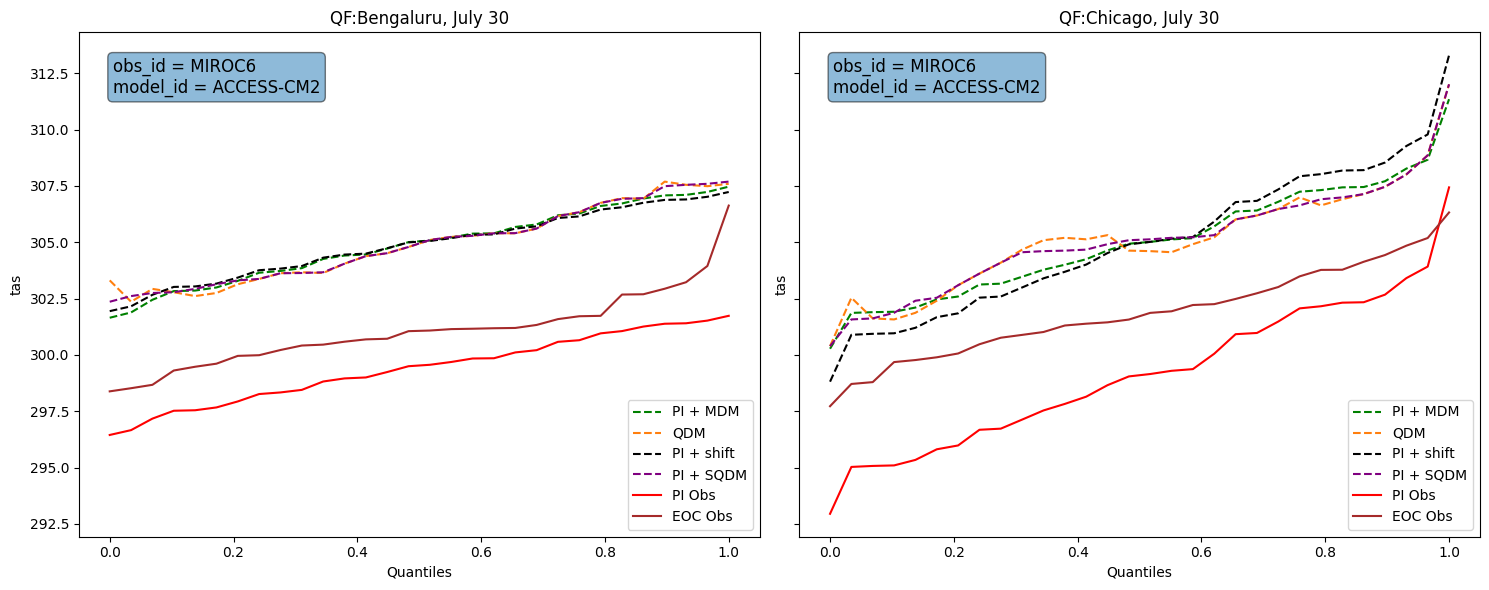

CPU times: user 2.08 s, sys: 55 ms, total: 2.14 s
Wall time: 24.4 s


In [34]:
%%time
# Plot quantile curves side by side for both locations
fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

for ax, (location, data) in zip(axs, quantile_data.items()):
    for key, value in variables.items():
        ax.plot(quants, data[key], value['style'], color=value['color'], label=value['label'])
    # Add labels, title, legend, and text
    text_str = f'obs_id = {obs_id}\nmodel_id = {model_id}'
    ax.set_xlabel('Quantiles')
    ax.set_ylabel(var_name)
    ax.set_title('QF:'+ location + ', ' + date)
    ax.text(0.05, 0.95, text_str, transform=ax.transAxes, fontsize=12,
             verticalalignment='top', bbox=dict(boxstyle="round", alpha=0.5))
    ax.legend(loc='lower right')

plt.tight_layout()
plt.show()

In [35]:
%%time
# Dictionary to store sortedness check results
sorted_results = {}

# Loop through locations and variables
for location, data in quantile_data.items():
    sorted_results[location] = {}
    for key, array in data.items():
        # Check if the quantile values are sorted
        sorted_results[location][key] = is_sorted(array.values)

# Display Results
print("Quantile Function Sortedness Check:")
for location, results in sorted_results.items():
    print(f"\nLocation: {location}")
    for key, is_sorted_flag in results.items():
        status = "Sorted" if is_sorted_flag else "Not Sorted"
        print(f"  {key}: {status}")

Quantile Function Sortedness Check:

Location: Bengaluru
  qpi_mdm: Sorted
  qpi_qdm: Not Sorted
  qpi_shift: Sorted
  qpi_sqdm: Sorted
  qpi_obs: Sorted
  qeoc_obs: Sorted

Location: Chicago
  qpi_mdm: Sorted
  qpi_qdm: Not Sorted
  qpi_shift: Sorted
  qpi_sqdm: Sorted
  qpi_obs: Sorted
  qeoc_obs: Sorted
CPU times: user 1.29 s, sys: 32.1 ms, total: 1.32 s
Wall time: 16.1 s


In [36]:
%%time
# List of variables for which to calculate RMSE against qeoc_obs
target_vars = ['qpi_qdm', 'qpi_mdm', 'qpi_sqdm','qpi_shift']

# Dictionary to store RMSE results
rmse_results = {}

# Loop through locations and calculate RMSE
for location, data in quantile_data.items():
    rmse_results[location] = {}
    for var in target_vars:
        # Calculate RMSE against qeoc_obs
        rmse = xs.rmse(data[var], data['qeoc_obs'], dim='quantile')
        rmse_results[location][var] = rmse.values

# Display Results
print("RMSE Values for Quantile Functions:")
for location, results in rmse_results.items():
    print(f"\nLocation: {location}")
    for var, rmse_value in results.items():
        print(f"  {var}: RMSE = {rmse_value}")

RMSE Values for Quantile Functions:

Location: Bengaluru
  qpi_qdm: RMSE = 3.9121669993859913
  qpi_mdm: RMSE = 3.861469646621233
  qpi_sqdm: RMSE = 3.8989590606152973
  qpi_shift: RMSE = 3.8596937496474366

Location: Chicago
  qpi_qdm: RMSE = 3.3162094173217844
  qpi_mdm: RMSE = 3.2055242956495604
  qpi_sqdm: RMSE = 3.2919957948633054
  qpi_shift: RMSE = 3.4087960057814453
CPU times: user 2.33 s, sys: 25.8 ms, total: 2.35 s
Wall time: 28.9 s


### Compute global mean of absolute error 
- Quantile function after applying mdm on model pre-ind quantile function is denoted qpi_mdm using some qeoc_obs
- `Observed' end-of-21st-century quantile function is qeoc_obs
- Therefore, error for a give model and obs pair is defined as qpi_mdm - qeoc_obs. 
- Here, qeoc_obs0 is used instead of qeoc_obs to implement this computation using xarray broadcasting
- We then take the absolute value of this quantitiy and compute global mean

In [37]:
mdm_abserr   = np.fabs(qeoc_obs - qpi_mdm)
shift_abserr = np.fabs(qeoc_obs - qpi_shift)
# mdm_abserr 

In [38]:
# Mean absolute Error, where mean is global and annual mean
mdm_mae   = global_mean(mdm_abserr)
shift_mae = global_mean(shift_abserr)
mdm_mae

<xarray.DataArray (quantile: 30, obs_id: 20, model_id: 20)> Size: 96kB
dask.array<mean_agg-aggregate, shape=(30, 20, 20), dtype=float64, chunksize=(30, 3, 20), chunktype=numpy.ndarray>
Coordinates:
  * obs_id    (obs_id) <U17 1kB 'ACCESS-CM2' 'AWI-CM-1-1-MR' ... 'NorESM2-MM'
  * quantile  (quantile) float64 240B 0.0 0.03448 0.06897 ... 0.931 0.9655 1.0
  * model_id  (model_id) <U17 1kB 'ACCESS-CM2' 'AWI-CM-1-1-MR' ... 'NorESM2-MM'

In [39]:
# %%time
# mdm_mae.rename(var_name).to_dataset().to_zarr(folder_path +'cmip6_mdm_mae_380examples.zarr',mode='w')
# shift_mae.rename(var_name).to_dataset().to_zarr(folder_path +'cmip6_shift_mae_380examples.zarr',mode='w')

Text(0.5, 1.0, 'MDM and Shift-only')

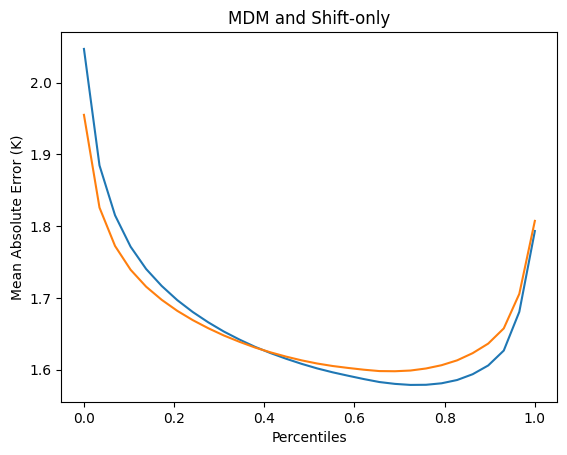

In [40]:
mdm_mae   = xr.open_zarr(folder_path +'cmip6_mdm_mae_380examples.zarr')
shift_mae = xr.open_zarr(folder_path +'cmip6_shift_mae_380examples.zarr')
mdm_mae   = mdm_mae[var_name]
shift_mae = shift_mae[var_name]
#
mdm_mae.sel(model_id=model_id,obs_id=obs_id).plot()
shift_mae.sel(model_id=model_id,obs_id=obs_id).plot()
plt.ylabel('Mean Absolute Error (K)')
plt.xlabel('Percentiles')
plt.title('MDM and Shift-only')

### Calculate Mean Absolute Error for sorted QDM

In [41]:
sqdm_abserr = np.fabs(qeoc_obs - qpi_sqdm)
sqdm_mae = global_mean(sqdm_abserr)

In [42]:
# %%time
# sqdm_mae.rename(var_name).to_dataset().to_zarr(folder_path +'cmip6_sqdm_mae_380examples.zarr',mode='w')

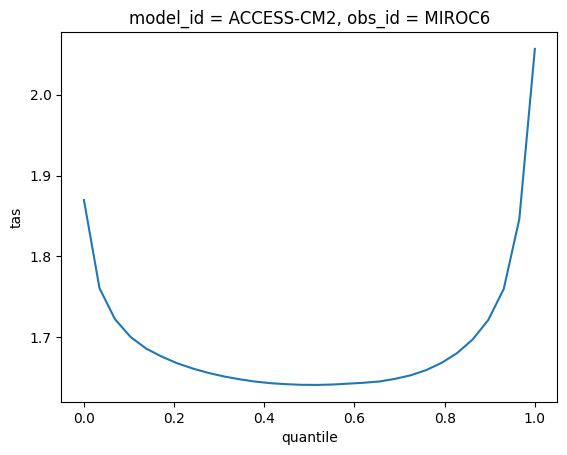

In [43]:
sqdm_mae = xr.open_zarr(folder_path +'cmip6_sqdm_mae_380examples.zarr')
sqdm_mae = sqdm_mae[var_name]
sqdm_mae.sel(model_id=model_id,obs_id=obs_id).plot()

## Calculate mean of mean absolute error over (obs_id,model_id) pairs 
 - Recall that MAE for a given (obs,model) pair is computed as a global mean and mean overy days of the year.

In [44]:
%%time
# Create a mask where 'obs_id' and 'model_id' do not match
mask = xr.DataArray(
    [[obs != model for model in mdm_mae.model_id.values] for obs in mdm_mae.obs_id.values], 
    dims=['obs_id', 'model_id'], 
    coords={'obs_id': mdm_mae.obs_id, 'model_id': mdm_mae.model_id}
)

# Expand mask to align with the quantile dimension
mask = mask.expand_dims({'quantile':mdm_mae['quantile'].values})

# # Apply the mask to the data array
# masked_da = mdm_mae.where(mask)
mask

CPU times: user 3.31 ms, sys: 0 ns, total: 3.31 ms
Wall time: 3.4 ms


<xarray.DataArray (quantile: 30, obs_id: 20, model_id: 20)> Size: 12kB
array([[[False,  True,  True, ...,  True,  True,  True],
        [ True, False,  True, ...,  True,  True,  True],
        [ True,  True, False, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ..., False,  True,  True],
        [ True,  True,  True, ...,  True, False,  True],
        [ True,  True,  True, ...,  True,  True, False]],

       [[False,  True,  True, ...,  True,  True,  True],
        [ True, False,  True, ...,  True,  True,  True],
        [ True,  True, False, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ..., False,  True,  True],
        [ True,  True,  True, ...,  True, False,  True],
        [ True,  True,  True, ...,  True,  True, False]],

       [[False,  True,  True, ...,  True,  True,  True],
        [ True, False,  True, ...,  True,  True,  True],
        [ True,  True, False, ...,  True,  True,  True],
        ...,
...
        ...,
        [ True,  True,  True, ..., False,  True,  True],
        [ True,  True,  True, ...,  True, False,  True],
        [ True,  True,  True, ...,  True,  True, False]],

       [[False,  True,  True, ...,  True,  True,  True],
        [ True, False,  True, ...,  True,  True,  True],
        [ True,  True, False, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ..., False,  True,  True],
        [ True,  True,  True, ...,  True, False,  True],
        [ True,  True,  True, ...,  True,  True, False]],

       [[False,  True,  True, ...,  True,  True,  True],
        [ True, False,  True, ...,  True,  True,  True],
        [ True,  True, False, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ..., False,  True,  True],
        [ True,  True,  True, ...,  True, False,  True],
        [ True,  True,  True, ...,  True,  True, False]]])
Coordinates:
  * quantile  (quantile) float64 240B 0.0 0.03448 0.06897 ... 0.931 0.9655 1.0
  * obs_id    (obs_id) <U17 1kB 'ACCESS-CM2' 'AWI-CM-1-1-MR' ... 'NorESM2-MM'
  * model_id  (model_id) <U17 1kB 'ACCESS-CM2' 'AWI-CM-1-1-MR' ... 'NorESM2-MM'

In [45]:
# Apply the mask to the data array
masked_mdm_mae   = mdm_mae.where(mask)
masked_sqdm_mae  = sqdm_mae.where(mask)
masked_shift_mae = shift_mae.where(mask)
masked_sqdm_mae

<xarray.DataArray 'tas' (quantile: 30, obs_id: 20, model_id: 20)> Size: 96kB
dask.array<where, shape=(30, 20, 20), dtype=float64, chunksize=(30, 3, 3), chunktype=numpy.ndarray>
Coordinates:
  * model_id  (model_id) <U17 1kB 'ACCESS-CM2' 'AWI-CM-1-1-MR' ... 'NorESM2-MM'
  * obs_id    (obs_id) <U17 1kB 'ACCESS-CM2' 'AWI-CM-1-1-MR' ... 'NorESM2-MM'
  * quantile  (quantile) float64 240B 0.0 0.03448 0.06897 ... 0.931 0.9655 1.0

In [46]:
# Calculate the mean over 'obs_id' and 'model_id' where values do not match
average_mdm_mae    = masked_mdm_mae.mean(dim=['obs_id', 'model_id'],skipna=True)
average_sqdm_mae   = masked_sqdm_mae.mean(dim=['obs_id', 'model_id'],skipna=True)
average_shift_mae  = masked_shift_mae.mean(dim=['obs_id', 'model_id'],skipna=True)

In [47]:
%%time
average_mdm_mae.to_dataset().to_zarr(folder_path + 'cmip6_mdm_mae_avg380pairs.zarr',mode='w')
average_sqdm_mae.to_dataset().to_zarr(folder_path + 'cmip6_sqdm_mae_avg380pairs.zarr',mode='w')
average_mdm_mae.to_dataset().to_zarr(folder_path  + 'cmip6_mdm_mae_avg380pairs.zarr',mode='w')
average_sqdm_mae.to_dataset().to_zarr(folder_path + 'cmip6_sqdm_mae_avg380pairs.zarr',mode='w')
average_shift_mae.to_dataset().to_zarr(folder_path  + 'cmip6_shift_mae_avg380pairs.zarr',mode='w')

CPU times: user 345 ms, sys: 26.6 ms, total: 372 ms
Wall time: 761 ms


In [48]:
#
average_mdm_mae    = xr.open_zarr(folder_path + 'cmip6_mdm_mae_avg380pairs.zarr')
average_sqdm_mae   = xr.open_zarr(folder_path + 'cmip6_sqdm_mae_avg380pairs.zarr')
average_shift_mae  = xr.open_zarr(folder_path + 'cmip6_shift_mae_avg380pairs.zarr')
#
average_mdm_mae    = average_mdm_mae[var_name]
average_sqdm_mae   = average_sqdm_mae[var_name]
average_shift_mae  = average_shift_mae[var_name]

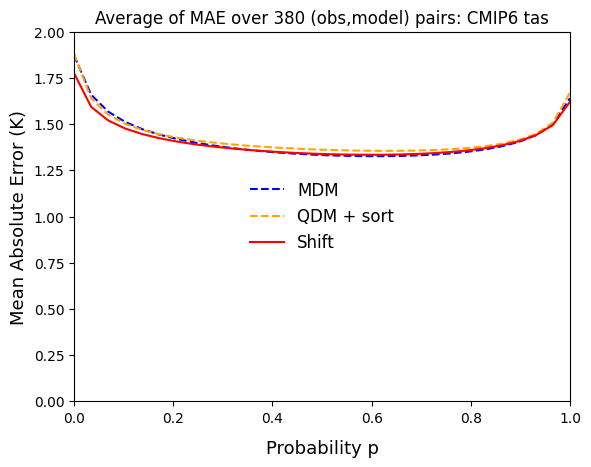

CPU times: user 118 ms, sys: 24.9 ms, total: 143 ms
Wall time: 160 ms


In [52]:
%%time
quants30        = np.linspace(0,1.0,30)
plt.plot(quants30,average_mdm_mae,'--',label='MDM',color = 'blue')
plt.plot(quants30,average_sqdm_mae,'--',label='QDM + sort',color = 'orange')
#plt.plot(quants30,qano_std_agmean,'-.',color='tab:gray',markersize=4)
plt.plot(quants30,average_shift_mae,label='Shift', color = 'red')
plt.legend(loc='center',prop={'size':12},frameon=False)
#
plt.title(f'Average of MAE over 380 (obs,model) pairs: CMIP6 {var_name}')
plt.ylabel('Mean Absolute Error (K)',fontsize=13)
plt.xlabel('Probability p',fontsize=13,labelpad=10)
plt.xlim(0.0,1.0)
plt.ylim(0.0,2.0)
plt.show()

In [50]:
cluster.close()